In [1]:
# import libraries

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

2024-08-01 20:08:43.968904: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# download Apple Stock Price data from 2012-01-01 to 2024-01-01

import yfinance as yf

df = yf.download('AAPl', start = '2012-01-01', end='2024-01-01')

[*********************100%%**********************]  1 of 1 completed


In [5]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,14.621429,14.732143,14.607143,14.686786,12.416982,302220800
2012-01-04,14.642857,14.810000,14.617143,14.765714,12.483714,260022000
2012-01-05,14.819643,14.948214,14.738214,14.929643,12.622307,271269600
2012-01-06,14.991786,15.098214,14.972143,15.085714,12.754257,318292800
2012-01-09,15.196429,15.276786,15.048214,15.061786,12.734028,394024400
...,...,...,...,...,...,...
2023-12-22,195.179993,195.410004,192.970001,193.600006,193.091385,37122800
2023-12-26,193.610001,193.889999,192.830002,193.050003,192.542816,28919300
2023-12-27,192.490005,193.500000,191.089996,193.149994,192.642548,48087700


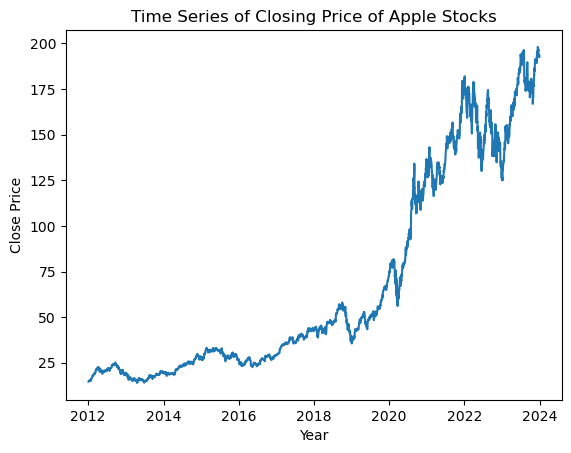

In [83]:
# Plot a graph

plt.plot(df.index, df['Close'])
plt.title('Time Series of Closing Price of Apple Stocks')
plt.xlabel('Year')
plt.ylabel('Close Price')
plt.show()

In [9]:
# Create a new dataframe of only close values

df1 = df.reset_index()['Close']

In [11]:
df1

0        14.686786
1        14.765714
2        14.929643
3        15.085714
4        15.061786
           ...    
3013    193.600006
3014    193.050003
3015    193.149994
3016    193.580002
3017    192.529999
Name: Close, Length: 3018, dtype: float64

In [46]:
# Convert df1 to an array,
# Transform values from df1 to be between 0 and 1,
# reshape the array into a single column

scaler = MinMaxScaler()
df2 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [44]:
df2

array([[0.00401431],
       [0.00444289],
       [0.00533302],
       ...,
       [0.97306723],
       [0.97540217],
       [0.96970066]])

In [15]:
# training_data_length is 80% of length of df2
# train_data is first 80% of Values from df2
# test_data is last 20% of Values from df2

training_data_length = int(len(df2)*0.8)
train_data, test_data = df2[:training_data_length], df2[training_data_length:]

In [17]:
n_past = 60     # number of past data values to consider for each data sample

x_train, y_train = [],[]

for i in range(n_past, len(train_data)):
    x_train.append(train_data[i - n_past:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_test, y_test = [],[]

for i in range(n_past, len(test_data)):
    x_test.append(test_data[i - n_past:i, 0])
    y_test.append(test_data[i, 0])
    
x_test, y_test = np.array(x_test), np.array(y_test)

In [71]:
print(x_train.shape), print(y_train.shape)

(2354, 60, 1)
(2354,)


(None, None)

In [69]:
print(x_test.shape), print(y_test.shape)

(544, 60, 1)
(544,)


(None, None)

In [67]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [21]:
# Create a Long Short-Term Memory Model

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(1))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [27]:
model.fit(x_train, y_train, validation_data=[x_test, y_test], epochs=10, batch_size=32, verbose=1)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0103 - val_loss: 0.0037
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.0739e-04 - val_loss: 0.0024
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2.4998e-04 - val_loss: 0.0052
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 2.6271e-04 - val_loss: 0.0022
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 2.4153e-04 - val_loss: 0.0030
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 1.8726e-04 - val_loss: 0.0038
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 2.1564e-04 - val_loss: 0.0013
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - loss: 2.0080e-04 - val_loss: 0.0012
Epoch 9/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 2.1112e-04 - val_loss: 0.0011
Epoch 10/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - loss: 1.7123e-04 - val_loss: 0.0023


In [29]:
# Predict data for the train and test dataset

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [31]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [33]:
print(math.sqrt(mean_squared_error(y_train, train_predict)))
print(math.sqrt(mean_squared_error(y_test, test_predict)))

54.93498518419001
157.40153811825652


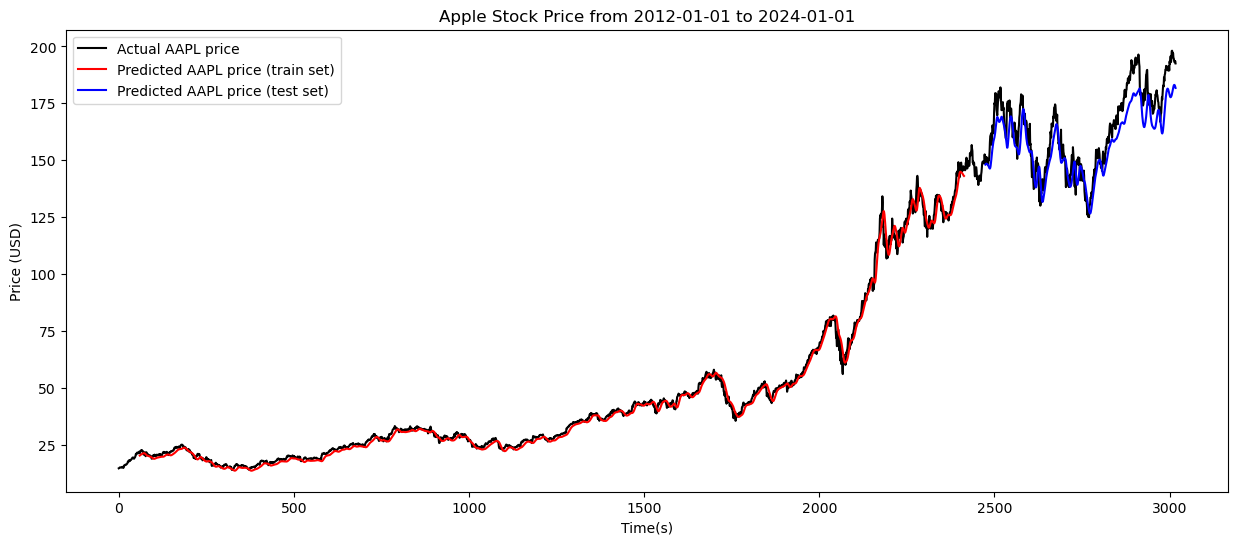

In [81]:
lb = 60     # number of previous data values to consider for prediction

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:] = np.nan
trainPredictPlot[lb:len(train_predict)+lb] = train_predict.flatten()

testPredictPlot = np.empty_like(df1)
testPredictPlot[:] = np.nan
test_start = len(df1) - len(test_predict)
testPredictPlot[test_start:] = test_predict.flatten()

original_scaled_data = scaler.inverse_transform(df2)

plt.figure(figsize=(15, 6))
plt.plot(original_scaled_data, color='black', label='Actual AAPL price')
plt.plot(trainPredictPlot, color='red', label='Predicted AAPL price (train set)')
plt.plot(testPredictPlot, color='blue', label='Predicted AAPL price (test set)')
plt.title('Apple Stock Price from 2012-01-01 to 2024-01-01')
plt.xlabel('Time(s)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()